<a href="https://colab.research.google.com/github/foroughi4/SHAP2NAM-An-Interpretable-Hybrid-Machine-Learning-Model-for-Heart-Disease-Prediction/blob/main/SHAP2NAM_MEng_Bardia_Foroughi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SHAP2NAM: AN INTERPRETABLE HYBRID MACHINE LEARNING MODEL FOR HEART DISEASE PREDICTION**

Bardia Foroughi


### Importing Libraries and Dependencies

In this block, we import all the essential libraries required for building, training, and evaluating the SHAP2NAM hybrid model for heart disease prediction.

*   **NumPy & Pandas**: For numerical computation and data manipulation (loading, cleaning, and processing the Cleveland dataset).
*   **Seaborn & Matplotlib**: For creating visualizations such as correlation heatmaps, SHAP plots, and NAM interpretability graphs.
*   **scikit-learn (sklearn)**: Provides preprocessing utilities (scaling, imputation, encoding), model evaluation metrics (accuracy, precision, recall, F1), and baseline classifiers (e.g., Random Forest).
*   **SHAP**: Used to compute feature attributions and identify the most influential first- and second-order feature interactions.
*   **PyTorch**: Framework for implementing the Neural Additive Model (NAM) architecture and training it on selected SHAP-based features.
*   **Other utilities (os, random, math, mpl_toolkits)**: Used for system interaction, reproducibility, mathematical operations, and 3D visualizations of feature interactions.

In [ ]:
import os
import random
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
import shap

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn

### Loading the Cleveland Heart Disease Dataset

This block downloads and prepares the dataset required for our SHAP2NAM model. The dataset comes from [Kaggle's UCI Heart Disease collection](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data), which includes multiple sources (Cleveland, Hungarian, Statlog, Switzerland). For consistency with prior research and to allow comparison with existing models, we specifically filter for the Cleveland subset, as it is the most widely used benchmark in literature

Steps:
1.   Use kagglehub to download the dataset locally
2.   Confirm that the files were downloaded by listing the directory contents.
3.   Load the dataset into a Pandas DataFrame.
4.   Filter the records to only include those labeled as “Cleveland.”
5.   Reset the index to maintain clean row ordering.








In [ ]:
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print(os.listdir(path))

df = pd.read_csv(f"{path}/heart_disease_uci.csv")
df = df[df['dataset'] == 'Cleveland'].reset_index(drop=True) # Keep only the Cleveland subset, which is the standard benchmark dataset

['heart_disease_uci.csv']


### Inspecting Dataset Structure
This block provides a quick overview of the Cleveland dataset. Understanding the dataset structure is important before preprocessing and modeling.

`df.info()`: Summarizes the dataset, showing number of rows, column names, data types, and counts of non-null values (helps identify missing data).

`print(df.columns)`: Displays the list of column names to verify available features (e.g., age, sex, cholesterol, thalassemia).

In [ ]:
df.info()
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        304 non-null    int64  
 1   age       304 non-null    int64  
 2   sex       304 non-null    object 
 3   dataset   304 non-null    object 
 4   cp        304 non-null    object 
 5   trestbps  304 non-null    float64
 6   chol      304 non-null    float64
 7   fbs       304 non-null    object 
 8   restecg   304 non-null    object 
 9   thalch    304 non-null    float64
 10  exang     304 non-null    object 
 11  oldpeak   304 non-null    float64
 12  slope     303 non-null    object 
 13  ca        299 non-null    float64
 14  thal      301 non-null    object 
 15  num       304 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 38.1+ KB
Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'c

### Checking for Missing Values

This block identifies and visualizes missing data in the Cleveland dataset. Handling missing values is necessary because incomplete records can bias the model or reduce predictive accuracy.

Steps:
1.   **Calculate missing values:** Count how many null entries exist per column.
2.   **Compute percentage missing:** Express missingness as a percentage of the dataset size.
3.   **Create summary table:** Display both counts and percentages for quick review.
4.   **Visualize with heatmap:** Use Seaborn to highlight where missing values occur across samples and features.

          Missing Values  Percentage
id                     0    0.000000
age                    0    0.000000
sex                    0    0.000000
dataset                0    0.000000
cp                     0    0.000000
trestbps               0    0.000000
chol                   0    0.000000
fbs                    0    0.000000
restecg                0    0.000000
thalch                 0    0.000000
exang                  0    0.000000
oldpeak                0    0.000000
slope                  1    0.328947
ca                     5    1.644737
thal                   3    0.986842
num                    0    0.000000


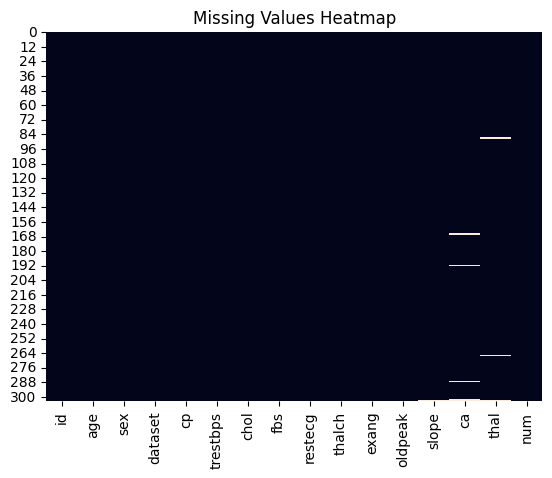

In [ ]:
missing_values = df.isnull().sum() # Count missing values per column

missing_percentage = (missing_values / len(df)) * 100 # Calculate percentage of missing values

# Combine into a summary DataFrame
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
    })

print(missing_info)

# Visualize missing data locations across the dataset with a heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

### Correlation Analysis of Raw Features

This block examines how the numeric features in the Cleveland dataset relate to one another before preprocessing. Correlation analysis is a useful diagnostic step to detect multicollinearity, which can impact model stability and interpretability.

Multicollinearity occurs when two or more independent variables are highly correlated with each other, meaning they carry overlapping or redundant information. Multicollinearity matters because it reduces interpretability (making it difficult to know which feature is driving predictions), can destabilize certain models and lead to unnecessary computation.

Steps:
1.   **Drop irrelevant columns**: Remove identifiers (`id`), dataset labels (`dataset`), and target labels (`num`, `target`).
2.   **Select numeric features**: Focus only on continuous/numeric variables for correlation computation.
3.    **Compute correlation matrix:** Use Pearson's correlation coefficient (`r`) to measure linear relationships between features.
4.    **Visualize with heatmap**: Show strength and direction of correlations (blue = positive, red = negative).

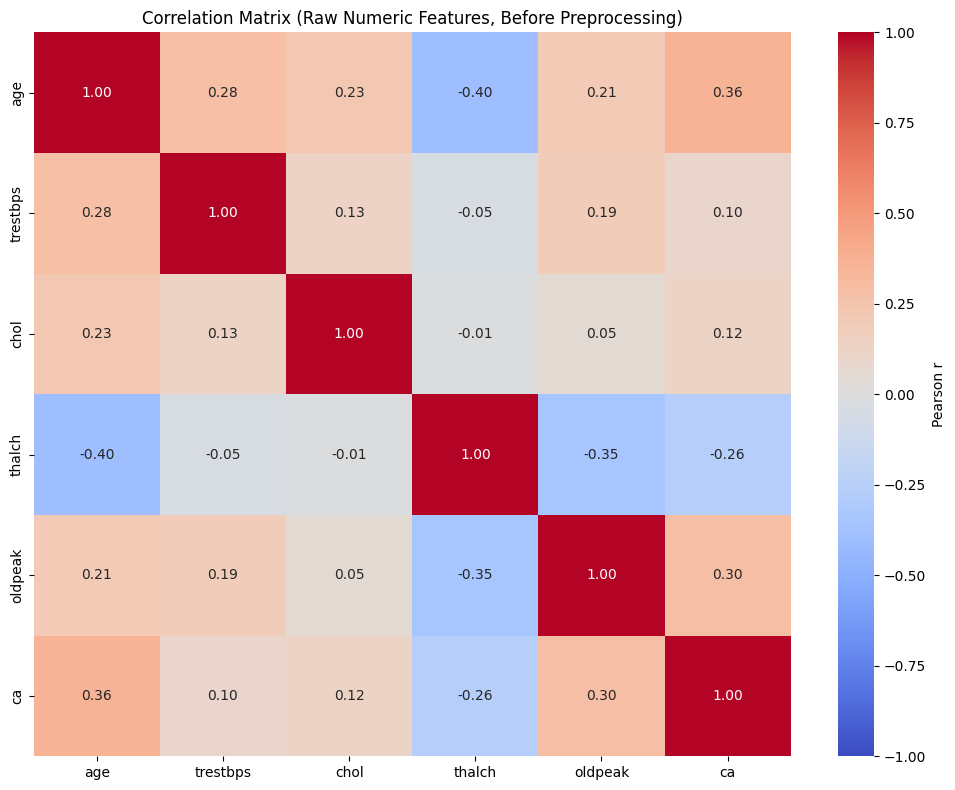

In [ ]:
raw_X = df.drop(columns=['id','num','target','dataset'], errors='ignore') # Remove ID, target, and dataset columns to focus on features only

num_cols = raw_X.select_dtypes(include=['number']).columns # Select only numeric columns

corr_raw = raw_X[num_cols].corr() # Compute correlation matrix for numeric features

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={'label': 'Pearson r'})
plt.title("Correlation Matrix (Raw Numeric Features, Before Preprocessing)")
plt.tight_layout()
plt.show()

### Data Preprocessing
This block prepares the Cleveland dataset for machine learning by cleaning, encoding, imputing, and scaling features. Proper preprocessing ensures that the SHAP2NAM pipeline receives well-structured, numeric inputs.

Steps:
1.   **Define Features and Target:**
*   Drop identifiers (id, dataset) and raw target columns (num, target).
*   Define `y` as a binary classification target: patients with heart disease (`num` > 0) are labeled 1, others 0

2.   **Fix Naming Inconsistencies:** Rename `thalch` → `thalach`(to align with literature-standard feature name for maximum heart rate achieved)

3. **Convert Categorical Binaries:** Convert `sex`, `fbs`, and `exang` from string/object to binary integers (0/1)

4.   **Handling Multiclass Categorical Variables:** The features `cp`, `restecg` , and `slope` are imputed with their most frequent value if missing, then expanded into dummy variables using one-hot encoding.

5. **Handling Numeric Feature:** Features such as `age`, `trestbps`, `chol`, `thalach`, `oldpeak`, and `ca` are imputed with IterativeImputer and standardized with StandardScaler.

6.   **Transform Dataset & Split**: Apply the combined transformations with ColumnTransformer. Split into training (80%) and testing (20%) sets, ensuring the class balance is preserved

7.    **Validation Checks**: Confirm that the processed feature count matches expected names.

In [ ]:
# Define features (X) and target (y)
X = df.drop(columns=['id', 'num', 'target', 'dataset'], errors='ignore').copy()
y = (df['num'] > 0).astype(int) if 'target' not in df else df['target']

if 'thalach' not in X.columns and 'thalch' in X.columns: # Fix feature naming inconsistency: "thalch" -> "thalach"
    X.rename(columns={'thalch': 'thalach'}, inplace=True)

# Convert certain categorical/binary columns to integer format
for col, truthy in [('sex', ['male', 'm', '1', 'true']),
                    ('fbs', ['true', '1']),
                    ('exang', ['true', '1'])]:
    if col in X.columns and X[col].dtype == 'object':
        X[col] = X[col].astype(str).str.lower().isin(truthy).astype(int)

# Separate numeric and categorical columns
numeric_cols = [c for c in ['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak','ca'] if c in X.columns]
cat_cols     = [c for c in ['cp','restecg','slope'] if c in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', IterativeImputer(random_state=42)),  # Handling missing values using IterativeImputer
            ('scaler', StandardScaler())  # Standardize numeric features
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), # Handling missing values using most frequent value
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore',
                                      sparse_output=False))  # Encode categories
        ]), cat_cols),
    ],
    remainder='drop'
)


X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Train-test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Validation checks
print("X_processed shape:", X_processed.shape)
print("len(feature_names):", len(feature_names))
assert X_processed.shape[1] == len(feature_names), "Feature name count mismatch."

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df  = pd.DataFrame(X_test,  columns=feature_names)
print("Train/Test shapes:", X_train_df.shape, X_test_df.shape)
print("Column names:", list(X_train_df.columns))


X_processed shape: (304, 16)
len(feature_names): 16
Train/Test shapes: (243, 16) (61, 16)
Column names: ['num__age', 'num__sex', 'num__trestbps', 'num__chol', 'num__fbs', 'num__thalach', 'num__exang', 'num__oldpeak', 'num__ca', 'cat__cp_atypical angina', 'cat__cp_non-anginal', 'cat__cp_typical angina', 'cat__restecg_normal', 'cat__restecg_st-t abnormality', 'cat__slope_flat', 'cat__slope_upsloping']


### Correlation Analysis After Preprocessing
This block examines correlations between features after preprocessing to see how transformations like imputation, scaling, and one-hot encoding affect feature relationships.

Steps:
1.   **Convert to DataFrame**: The processed feature matrix (`X_processed`) is converted into a DataFrame with proper column names.
2.   **Compute correlation matrix**: Use Pearson's correlation coefficient (`r`) to measure linear relationships between features.
3.   **Visualize with heatmap**: Show strength and direction of correlations (blue = positive, red = negative).

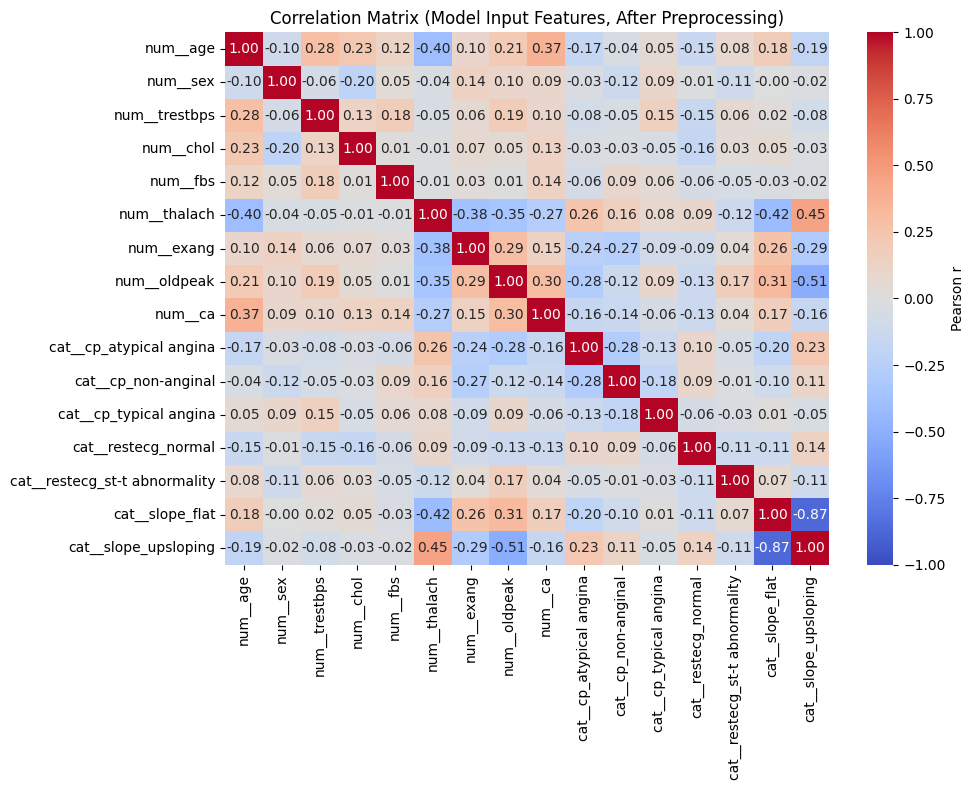

In [ ]:
X_processed_df = pd.DataFrame(X_processed, columns=feature_names) # Convert processed features into a DataFrame for interpretability

corr = X_processed_df.corr() # Compute correlation matrix on preprocessed features

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={'label': 'Pearson r'})
plt.title("Correlation Matrix (Model Input Features, After Preprocessing)")
plt.tight_layout()
plt.show()

### SHAP Interaction Analysis with Random Forest

This block trains a baseline tree model and extracts pairwise SHAP interaction strengths to decide which feature pairs to keep for the second-order NAM.

Steps:
1.   **Prepare Feature Matrix**: Retrieve input_features from the preprocessor and convert `X_train`, `X_test` to DataFrames with named columns for interpretability.

2.   **Train Baseline Model**: Fit a RandomForestClassifier (`n_estimators=100`, fixed `random_state`) on the preprocessed training data.

3.   **Compute SHAP Interaction Values**:
      *   Create a `shap.TreeExplainer` for the trained forest.
      *   Call `explainer.shap_interaction_values(X_train_df)` to obtain interaction tensors (per-sample, per-feature-pair).

4. **Reduce to a Feature × Feature Matrix**:
      *   Take the mean absolute value across samples to summarize importance.
      *   If the output is 3D, also average across classes (binary setting) to get a 2D matrix.
      *    Set the diagonal to 0 to remove self-interactions.

5.   **Rank Feature Pairs**:
      *   Enumerate all unique (`feature_i`, `feature_j`) pairs.
      *   Score each pair by its mean absolute interaction value.
      *   Sort and select the Top-20 pairs for second-order NAM terms.

6. **Validation Checks**:
      *   Print the matrix shapes before/after reduction.
      *   Display the top pairs with scores to guide which interactions to encode in the NAM.

In [ ]:
input_features = list(preprocessor.get_feature_names_out()) # Retrieve feature names from the preprocessor

# Convert train/test arrays back into DataFrames for interpretability
X_train_df = pd.DataFrame(X_train, columns=input_features)
X_test_df = pd.DataFrame(X_test, columns=input_features)

# Train a baseline Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_df, y_train)

explainer = shap.TreeExplainer(rf_model) # Create a SHAP explainer for the Random Forest

interaction_values = explainer.shap_interaction_values(X_train_df) # Compute SHAP interaction values

# Handle SHAP output shape
if isinstance(interaction_values, list):
    interactions = np.abs(interaction_values[1]).mean(axis=0) # For binary classification
else:
    interactions = np.abs(interaction_values).mean(axis=0)

print("Interaction shape before reduction:", interactions.shape)

# Reduce the 3D interaction tensor into a 2D feature × feature matrix
interactions = np.abs(interactions).mean(axis=2)
print("Reduced interaction shape:", interactions.shape)

np.fill_diagonal(interactions, 0) # Zero out self-interactions (diagonal)

# Collect all feature pairs with their interaction strength
interaction_pairs = []
for i in range(len(input_features)):
    for j in range(i + 1, len(input_features)):
        interaction_pairs.append(((input_features[i], input_features[j]), interactions[i, j]))

top_pairs = sorted(interaction_pairs, key=lambda x: x[1], reverse=True)[:20] # Rank top pairs by interaction strength and keep top 20

# Print strongest feature interactions
for (f1, f2), score in top_pairs:
    print(f"{f1} & {f2}: {score:.4f}")


Interaction shape before reduction: (16, 16, 2)
Reduced interaction shape: (16, 16)
num__thalach & num__ca: 0.0114
num__oldpeak & num__ca: 0.0086
num__chol & num__ca: 0.0081
num__thalach & num__oldpeak: 0.0078
num__age & num__ca: 0.0073
num__age & num__thalach: 0.0071
num__sex & num__ca: 0.0063
num__sex & num__exang: 0.0060
num__trestbps & num__ca: 0.0057
num__sex & num__thalach: 0.0055
num__exang & num__oldpeak: 0.0053
num__ca & cat__cp_non-anginal: 0.0050
num__ca & cat__slope_flat: 0.0049
num__trestbps & num__thalach: 0.0048
num__age & num__oldpeak: 0.0047
num__exang & cat__slope_flat: 0.0047
num__oldpeak & cat__slope_upsloping: 0.0047
num__thalach & num__exang: 0.0044
num__ca & cat__restecg_normal: 0.0044
num__sex & num__oldpeak: 0.0044


### SHAP2NAM Model (First- & Second-Order NAMs)

This block converts SHAP-selected feature pairs into index form and defines the Neural Additive Model (NAM) components used in SHAP2NAM. The model combines (1) first-order univariate subnetworks and (2) second-order pairwise subnetworks only for the top SHAP interaction pairs, then maps their summed output to a probability.

Steps:
1.   **Map features to indices**:
      *   Pull `input_features` from the preprocessor.
      *   Convert the top SHAP interaction pairs into index tuples (`pair_indices`) for fast tensor slicing.

2.   **First-Order NAM**:
       *   One small MLP per feature with input size 1 → hidden → 1.
       *   Forward: evaluate each feature's subnet, stack and sum the outputs → `f(x)`.

3.  **Second-Order NAM**:
      *   One small MLP per selected pair with input size 2 (the two features) → hidden → 1.
      *   Forward: concatenate each pair (`x_i, x_j`), run its subnet, stack and sum → `g(x)`.

4. **Multi-Order NAM (fusion + output)**:
      *   Total effect: `total = f(x) + g(x)`.
      *   A final linear layer (1 → 1) followed by sigmoid converts the additive score to a probability.

5. **Reproducibility**: Set seeds for `random`, `numpy`, and `torch` (incl. cuDNN flags) to make results reproducible.

6. **Create Model**: Build MultiOrderNAM with `num_features` and the SHAP-selected `pair_indices`.













In [ ]:
# Map SHAP-selected feature pairs to indices
input_features = list(preprocessor.get_feature_names_out())
feature_to_index = {feat: i for i, feat in enumerate(input_features)}
top_feature_pairs = [pair for pair, score in top_pairs]
pair_indices = [(feature_to_index[a], feature_to_index[b]) for a, b in top_feature_pairs]

# First-Order NAM: One net per single feature
class FirstOrderNAM(nn.Module):
    def __init__(self, num_features, hidden_dim=8):
        super().__init__()
        # List of 1D MLPS, each learns f_i(x_i)
        self.nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            ) for _ in range(num_features)
        ])
    # Evaluate each feature-specific net and sum: f(x) = SUM_i f_i(x_i)
    def forward(self, x):
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.nets)]
        return torch.sum(torch.stack(outputs, dim=1), dim=1)

# Second-Order NAM: One net per feature pair
class SecondOrderNAM(nn.Module):
    def __init__(self, pair_indices, hidden_dim=16):
        super().__init__()
        self.pair_indices = pair_indices
        # List of 2D MLPs, each learns g_ij(x_i, x_j)
        self.nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            ) for _ in pair_indices
        ])

    # Evaluate each pair-specific net and sum: g(x) = SUM_(i,j) g_ij(x_i, x_j)
    def forward(self, x):
        outputs = [
            net(torch.cat([x[:, i:i+1], x[:, j:j+1]], dim=1))
            for (i, j), net in zip(self.pair_indices, self.nets)
        ]
        return torch.sum(torch.stack(outputs, dim=1), dim=1)

# Multi-Order NAM: combines the first- and second-order effects and maps the probability
class MultiOrderNAM(nn.Module):
    def __init__(self, num_features, pair_indices):
        super().__init__()
        self.first_order = FirstOrderNAM(num_features)
        self.second_order = SecondOrderNAM(pair_indices)
        self.output_layer = nn.Linear(1, 1) # Maps additive score to logit for passing through sigmoid function

    def forward(self, x):
        f = self.first_order(x)
        g = self.second_order(x)
        total = f + g # Additive Model
        return torch.sigmoid(self.output_layer(total)) # Probability Score

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create Model
model = MultiOrderNAM(num_features=len(input_features), pair_indices=pair_indices)
print(model)

MultiOrderNAM(
  (first_order): FirstOrderNAM(
    (nets): ModuleList(
      (0-15): 16 x Sequential(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): ReLU()
        (2): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
  (second_order): SecondOrderNAM(
    (nets): ModuleList(
      (0-19): 20 x Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): ReLU()
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
    )
  )
  (output_layer): Linear(in_features=1, out_features=1, bias=True)
)


### Training the Multi-Order NAM
This block trains the SHAP2NAM model using the preprocessed Cleveland dataset. Both the first-order and second-order feature subnetworks are optimized jointly to minimize classification error.



*   **Tensor conversion**: Training and test sets are converted to PyTorch tensors (float32) so they can be used in the neural network. Labels (`y`) are reshaped into column vectors.
*   **Model setup**: The `MultiOrderNAM` is instantiated with the SHAP-selected feature pairs.
*   **Loss function**: Binary Cross-Entropy Loss (BCELoss) is used, appropriate for binary classification (heart disease vs. no disease).
*   **Optimizer**: Adam optimizer updates model weights with a learning rate of 0.001.
* **Training loop (200 epochs)**:
  *  Forward pass: Compute predictions for training set.
  *  Loss calculation: Compare predictions with true labels using BCE.
  *  Backpropagation: Update weights via gradient descent.
  *  Metrics: Compute and store accuracy after each epoch.
  *  Progress log: Print training loss and accuracy every 50 epochs.
* **Visualization**: Plot training loss and accuracy across epochs to monitor convergence.
* **Save model**: Final trained weights are saved to `'nam_final_model.pth'` for reuse in evaluation or deployment.

Epoch [50/200] - Loss: 0.4342, Accuracy: 0.8025
Epoch [100/200] - Loss: 0.3904, Accuracy: 0.8272
Epoch [150/200] - Loss: 0.3652, Accuracy: 0.8395
Epoch [200/200] - Loss: 0.3458, Accuracy: 0.8642


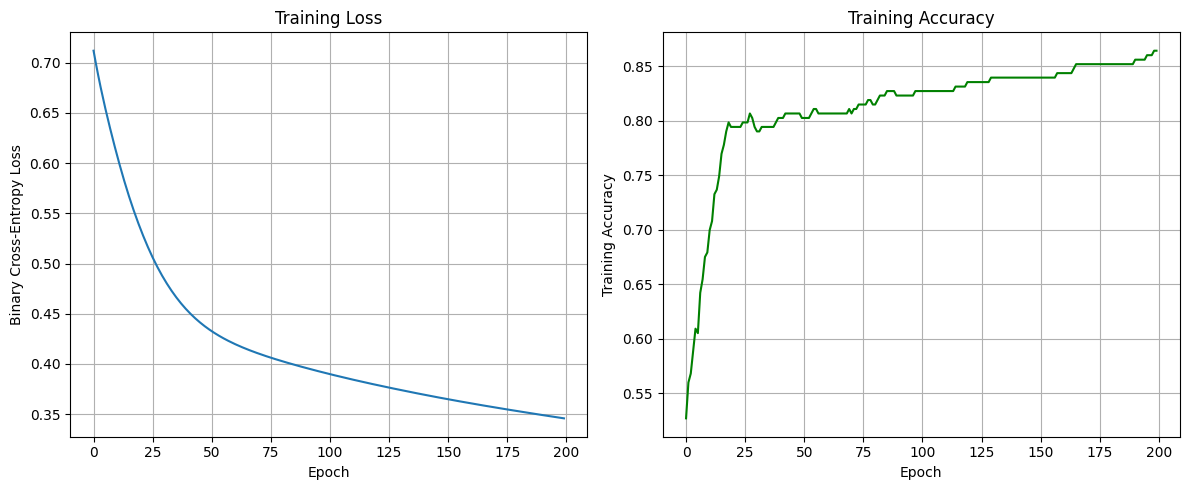

In [ ]:
# Convert NumPy arrays / Series to PyTorch tensors
# Use float32 for model inputs/targets, reshape y to column vector (N, 1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Initialize the Multi-Order NAM with SHAP-selected pair indices
model = MultiOrderNAM(num_features=len(input_features), pair_indices=pair_indices)

# Define Loss (Binary Cross-Entropy) and Optimizer (Adam)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Setting Learning = 0.001

# Tracking for plotting
losses = []
accuracies = []

# Training Loop
epochs = 200
for epoch in range(epochs):
    model.train() # Enable model training
    optimizer.zero_grad() # Reset gradients from previous step

    # Forward pass: predictions for entire training set
    outputs = model(X_train_tensor)  # shape of (N, 1), values in [0,1]
    loss = criterion(outputs, y_train_tensor) # BCE loss

    # Backpop and parameter update
    loss.backward()
    optimizer.step()

    # Storing metrics
    losses.append(loss.item())
    with torch.no_grad():
        preds = (outputs >= 0.5).int() # Convert probabilites to binary predictions at a threshold of 0.5
        acc = (preds == y_train_tensor.int()).float().mean().item() # Compare to true labels and compute accuracy
        accuracies.append(acc)

    # Print training loss and accuracy every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Plotting training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss')
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save trained model
torch.save(model.state_dict(), 'nam_final_model.pth')

### Model Evaluation on Test Set

This block evaluates the trained Multi-Order NAM on the test set. Unlike the training loop, the model is placed in evaluation mode to ensure no gradient updates occur.

*   **Evaluation mode**: `model.eval()` disables dropout/batchnorm randomness.
*   **Prediction**: The model outputs probabilities in [0,1]. A threshold of 0.5 converts these into binary class labels.
*   **Comparison with ground truth**: Predictions are compared against true labels from the test set.
*   **Metrics reported**:
      * Accuracy: Overall proportion of correct predictions.
      * Precision: Of those predicted positive, how many truly have heart disease.
      * Recall (Sensitivity): Of all patients with disease, how many were correctly identified.
      * F1 Score: Harmonic mean of precision and recall, balancing false positives and false negatives.

In [ ]:
# Model evaluation on test set
model.eval() # Enable model testing
with torch.no_grad(): # Disable gradient tracking
    y_pred_probs = model(X_test_tensor) # Predicted probabilities [0,1]
    y_pred_labels = (y_pred_probs >= 0.5).int() # Threshold at 0.5 for binary labels

# Convert tensors back to NumPy arrays for sklearn metrics
y_true = y_test_tensor.numpy()
y_pred = y_pred_labels.numpy()

# Printing evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


Accuracy: 0.9508196721311475
Precision: 0.9032258064516129
Recall: 1.0
F1 Score: 0.9491525423728814


### Plotting First-Order NAM Functions (Individual Features)

This block visualizes the learned first-order functions `f_i(x_i)`for every input feature in the NAM. Each subplot shows how a single standardized feature influences the model’s additive score (its contribution). These plots are useful for interpretability: increasing/decreasing trends, thresholds, or non-linear effects are directly visible per feature.

Steps:
1.   Puts the model in `eval mode` to freeze layers.
2.   For each feature `x_i`
builds a 1-D grid from the observed min to max(based on `X_train_tensor`) and runs the corresponding univariate subnetwork to get `f_i(x_i`).
3. Arranges subplots in a grid and labels each curve as `f(feature_name)`.



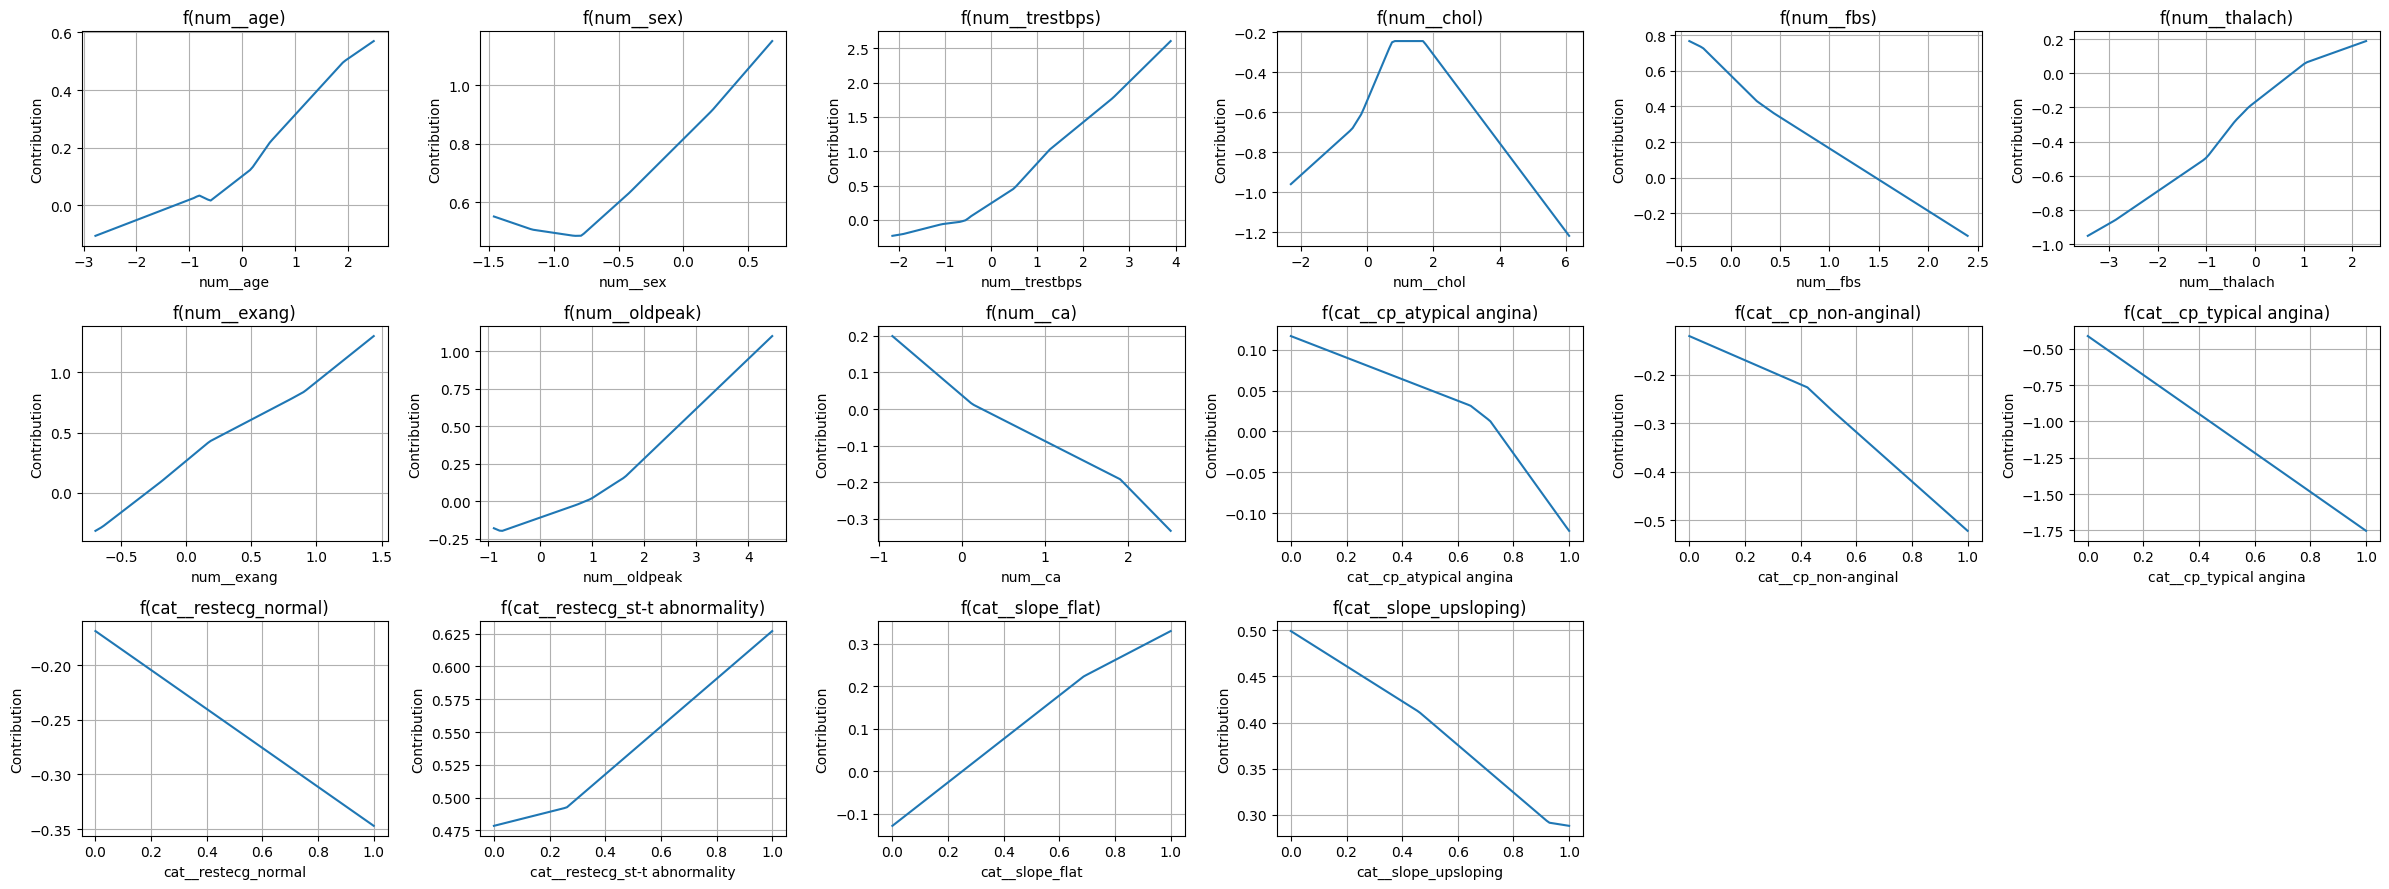

In [ ]:
def plot_first_order_grid(model, feature_names, X_train_tensor, resolution=100):
    model.eval() # Enable model testing

    num_features = len(feature_names)
    cols = 6
    rows = math.ceil(num_features / cols)

    # Create grid of subplots and flatten for easier indexing
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axs = axs.flatten()

    # Loop through each feature and its corresponding 1D subnetwork f_i
    for i, (net, name) in enumerate(zip(model.first_order.nets, feature_names)):
        # Determine plotting range from training data
        x_min = X_train_tensor[:, i].min().item()
        x_max = X_train_tensor[:, i].max().item()
        # Creating 1D grid over features range
        x = torch.linspace(x_min, x_max, resolution).view(-1, 1)

        # Evalute univariate function f_i(x_i) without gradient tracking
        with torch.no_grad():
            y = net(x).cpu().numpy()

        # Plotting contribution curve for selected feature
        axs[i].plot(x.cpu().numpy(), y)
        axs[i].set_title(f"f({name})")
        axs[i].set_xlabel(name) # Feature
        axs[i].set_ylabel("Contribution") # Additive effect toward logit
        axs[i].grid(True)

    # Hide leftover empty subplots if feature count doesn't fill grid
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_first_order_grid(model, input_features, X_train_tensor) # Plot all learned first-order NAM functions for each feature

### Plotting Second-Order NAM Functions (Feature Pairs)

This block visualizes the learned pairwise functions `g_ij(x_i,x_j)` for the top SHAP-selected feature pairs. Each subplot is a 3D surface plot showing how two features jointly contribute to the NAM's additive score.

Steps:
1.   For each feature pair, a 2D grid of values (default: [-3,3] in standardized scale) is built using `torch.meshgrid`.
2.   The corresponding pairwise subnetwork processes all grid points to estimate contributions.
3.   Contributions are reshaped back into a grid and plotted as a 3D surface.
4.   Peaks/valleys in these plots reveal how feature interactions affect predicted heart disease risk.



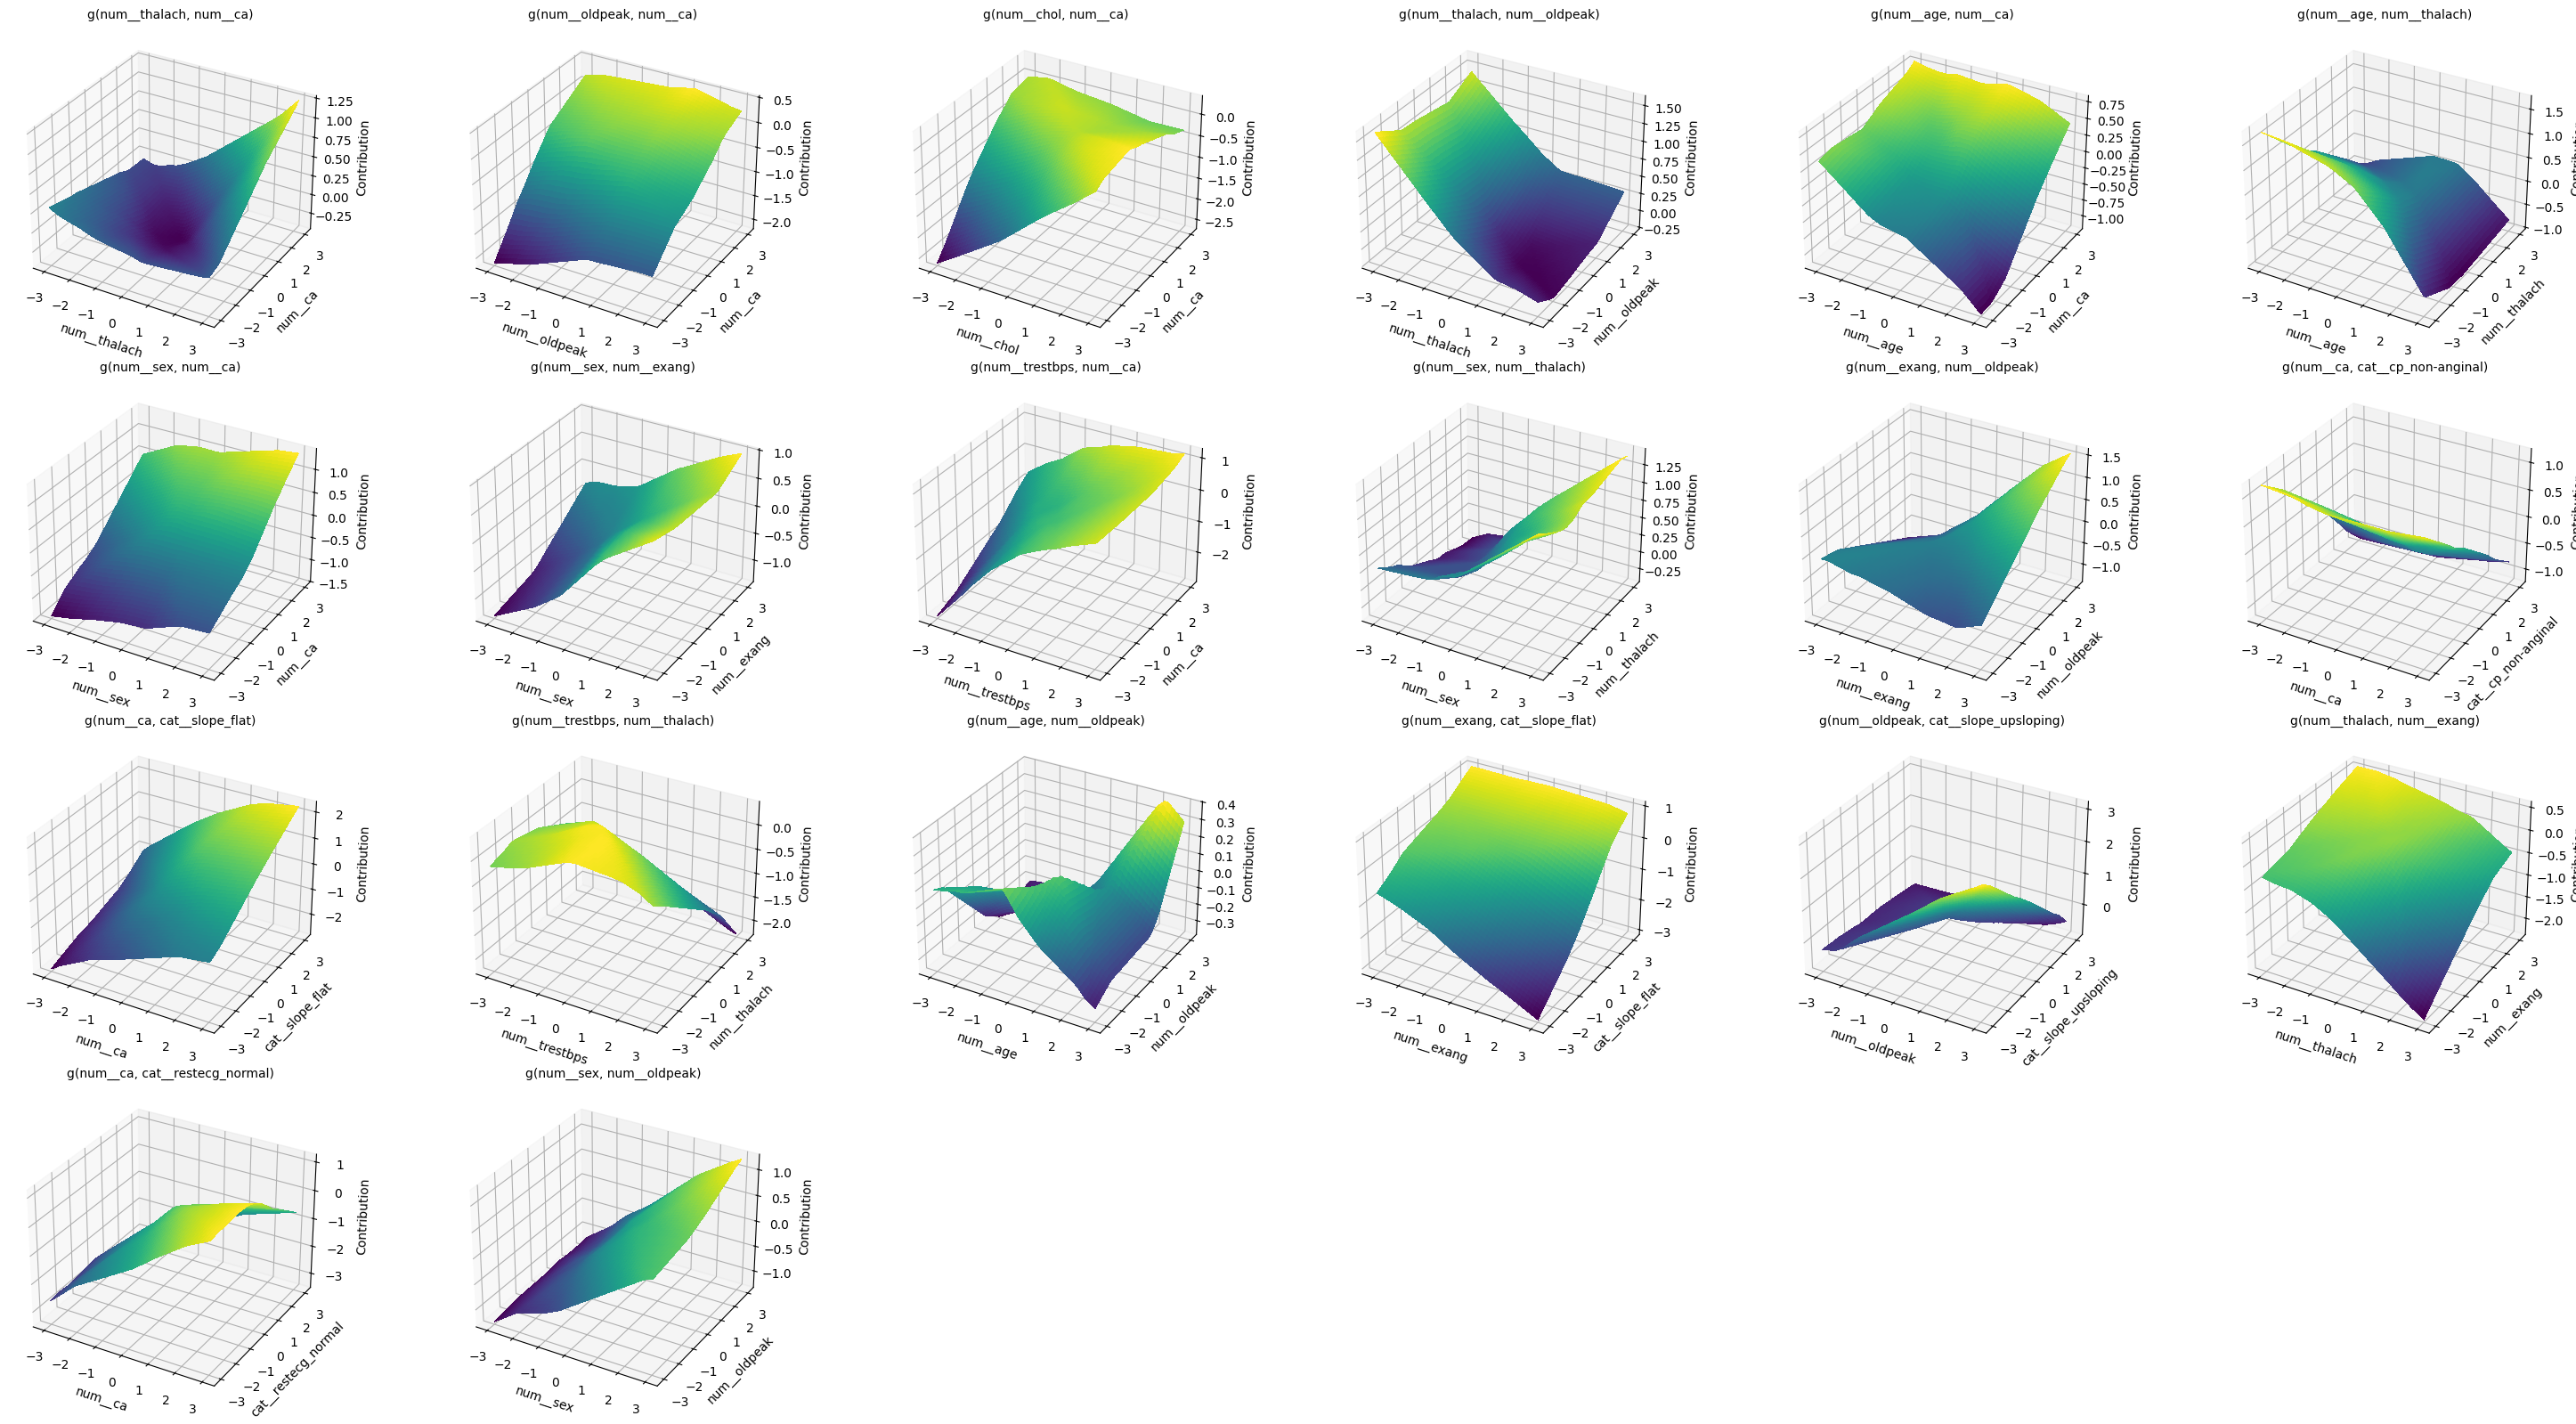

In [ ]:
def plot_second_order_grid(model, pair_indices, feature_names, resolution=50):
    model.eval() # Enable model testing

    num_pairs = len(pair_indices)
    cols = 6
    rows = math.ceil(num_pairs / cols)

    # Create a figure with appropraite size for multiple 3d plots
    fig = plt.figure(figsize=(cols * 5, rows * 4))

    # Loop through each SHAP-selected feature pair and its corresponding subnetwork
    for idx, ((i, j), net) in enumerate(zip(pair_indices, model.second_order.nets)):
        # Build a 2D grid of values for both features across a standardized range [-3, 3]
        xi = torch.linspace(-3, 3, resolution)
        xj = torch.linspace(-3, 3, resolution)
        xi_grid, xj_grid = torch.meshgrid(xi, xj, indexing='ij')

        # Stack the 2D grid into a tensor for model input
        inputs = torch.stack([xi_grid.reshape(-1), xj_grid.reshape(-1)], dim=1)

        # Evaluate the pairwise nework g_ij(x_i,x_j) over the entire grid
        with torch.no_grad():
            z = net(inputs).view(resolution, resolution).cpu().numpy()

        # Create a 3D subplot for the feature interaction
        ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')

        # Plot the interaction contribution as a 3D mesh
        ax.plot_surface(
            xi_grid.numpy(),
            xj_grid.numpy(),
            z,
            cmap=cm.viridis,
            linewidth=0,
            antialiased=False)

        ax.set_title(f"g({feature_names[i]}, {feature_names[j]})", fontsize=10)
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[j])
        ax.set_zlabel("Contribution")

    plt.tight_layout()
    plt.show()

plot_second_order_grid(model, pair_indices, input_features)  # Plot all second-order NAM functions